# Learned Cost Model Evaluation

In [1]:
from copy import deepcopy
import os
import random
import sys
from typing import Any, Optional, Tuple, Type

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

pd.set_option('display.max_columns', 50)
pd.set_option('display.min_rows', 20)

In [3]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

In [4]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneDataGenerator
from endure.lsm.types import Policy, LSMDesign, System, LSMBounds, STR_POLICY_DICT
from endure.lsm.cost import EndureCost
from endure.lcm.util import create_input_from_types

In [5]:
def save_fig(fig, filename, **kwargs):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight', **kwargs)

In [6]:
model_path = '/scratchNVMe/ndhuynh/other_data/models/lcm/kcost_1205PM_090524/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
policy = getattr(Policy, config['lsm']['design'])
bounds = LSMBounds(**config['lsm']['bounds']) 

In [7]:
config['job']['LCMTrain']

{'max_epochs': 50,
 'save_dir': 'models/lcm/kcost_1205PM_090524',
 'no_checkpoint': False,
 'loss_fn': 'MSE',
 'optimizer': 'Adam',
 'lr_scheduler': 'Constant',
 'train': {'dir': 'train-data/lcm/klsm_large',
  'batch_size': 4096,
  'shuffle': True,
  'num_workers': 8,
  'drop_last': True},
 'test': {'dir': 'test-data/lcm/klsm',
  'batch_size': 16384,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [8]:
generator_class = Gen.get_generator(policy)
gen = generator_class(bounds)

# Loss Graph

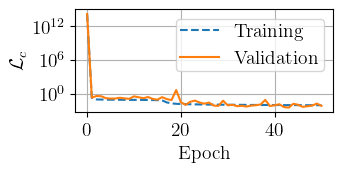

In [9]:
plt.rcParams.update({'font.size': 14})
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[0:]
fig, ax = plt.subplots(figsize=(width, 0.65*height))
ax.plot(losses['epoch'], losses['train_loss'], label='Training', linestyle='--')
ax.plot(losses['epoch'], losses['test_loss'], label='Validation', linestyle='-')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'$\mathcal{{L}}_c$')
ax.set_yscale('log')
ax.set_yticks([1e12,  1e6,  1e0])
ax.grid()
# ax.set_title('Learned Cost Model Loss')
_ = ax.legend(loc='upper right', borderpad=0.2)
# save_fig(fig, 'lcm_loss.pdf')

In [10]:
losses.idxmin()

epoch          0
train_loss    50
test_loss     43
dtype: int64

# Building

## Model

In [11]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_10.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)
builder = LearnedCostModelBuilder(
    size_ratio_range=bounds.size_ratio_range,
    max_levels=bounds.max_considered_levels,
    **config["lcm"]["model"]
)
model = builder.build_model(policy)
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [12]:
model

KapModel(
  (t_embedding): Linear(in_features=29, out_features=8, bias=True)
  (k_embedding): Linear(in_features=29, out_features=8, bias=True)
  (in_norm): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (in_layer): Linear(in_features=178, out_features=64, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (out_layer): Linear(in_features=64, out_features=64, bias=True)
  (z0): Linear(in_features=16, out_features=1, bias=True)
  (z1): Linear(in_features=16, out_features=1, bias=True)
  (q): Linear(in_features=16, out_features=1, bias=True)
  (w): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
example_input = create_input_from_types(design, system, z0, z1, q, w, bounds.size_ratio_range[0], bounds.size_ratio_range[1])
torchinfo.summary(model, example_input.unsqueeze(0).shape, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
KapModel                                 [1, 4]                    --
├─Linear: 1-1                            [1, 8]                    240
├─Linear: 1-2                            [1, 20, 8]                240
├─BatchNorm1d: 1-3                       [1, 178]                  356
├─Linear: 1-4                            [1, 64]                   11,456
├─ReLU: 1-5                              [1, 64]                   --
├─Dropout: 1-6                           [1, 64]                   --
├─Sequential: 1-7                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 64]                   4,160
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 64]                   4,160
│    └─ReLU: 2-4                         [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   4,160

# Utils

In [14]:
eval_util = LCMEvalUtil(bounds.size_ratio_range[0], bounds.size_ratio_range[1], bounds.max_considered_levels, model, gen)

In [15]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
# print(design)
# print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

(15.1313413137013, 15.162823677062988)

## LCM Evaluation

In [16]:
np.random.seed(2169)
num_samples = 5000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, row['z0'], row['z1'], row['q'], row['w'])
        bad.append((norm_delta, row['z0'], row['z1'], row['q'], row['w'], design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
# df.sort_values(by='norm_delta', ascending=False)

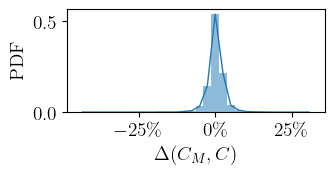

In [18]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(width, 0.65*height))
data = df['norm_delta'].values
hist, bins, _ = ax.hist(data, bins=30, alpha=0.5, weights=np.ones_like(data)/len(data))
# ax.hist(data, bins=50, density=True)
bin_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bin_center, hist, color='tab:blue', linewidth=1)
ax.set_xlabel('$\Delta(C_{M}, C)$')
ax.set_ylabel('PDF')
ax.xaxis.set_major_formatter(PercentFormatter(1))
save_fig(fig, 'lcm_normalized_cost.pdf')

In [19]:
cutoff = 0.1
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 10% delta: 99.000%


In [20]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)
    ax.set_yticks([0.5])

    ax.set_xlabel('Point-Reads', labelpad=10)
    ax.set_ylabel('Range-Reads', labelpad=10)
    ax.set_zlabel('Writes', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

In [21]:
# fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')
# cbar.set_label('Normalized Delta Cost')
# ax.set_title('Performance Over Workloads', pad=-10)
# save_fig(fig, 'lcm_delta_over_workload.pdf')

In [22]:
# fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)], 'norm_delta')

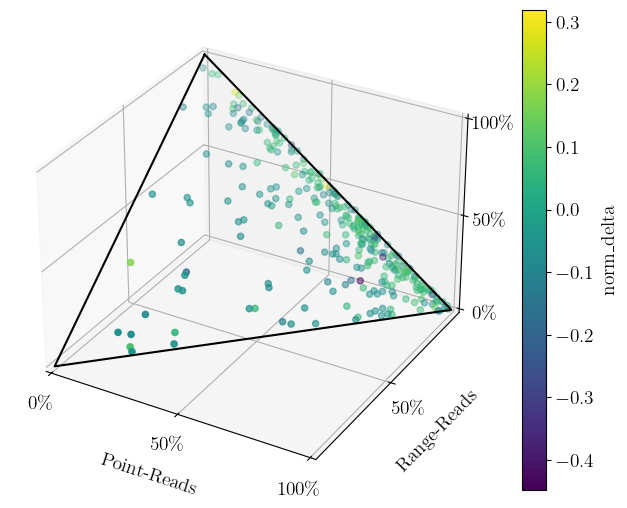

In [23]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)], 'norm_delta')

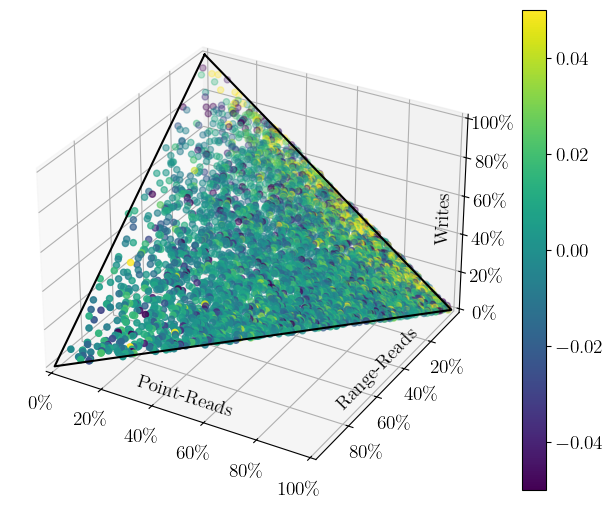

In [24]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)
# ax.set_yticks([0.5])

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)

sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df['norm_delta'], cmap='viridis', vmin=-0.05, vmax=0.05)
cbar = plt.colorbar(sc)
# cbar.set_label()

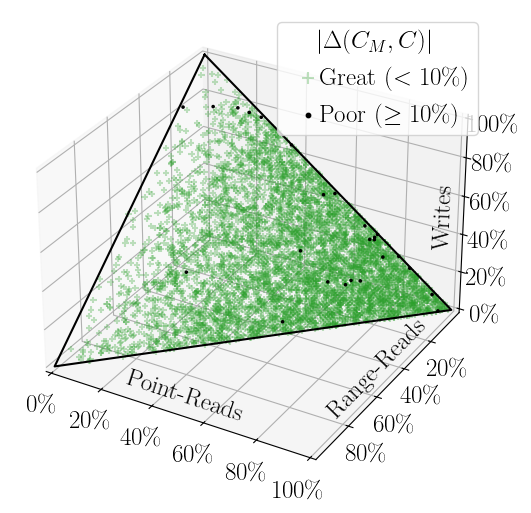

In [25]:
plt.rcParams.update({'font.size': 18})
cutoff = (0.1)
groupa = df[(df['norm_delta'] > -cutoff)]
groupb = df[(df['norm_delta'] < -cutoff)]

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label=f'Great ($<$ {cutoff*100:.0f}\%)', alpha=0.3, marker='+', color='tab:green', rasterized=True)
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor ($\ge$ {cutoff*100:.0f}\%)', alpha=1, marker='.', color='black', rasterized=True, s=10)
# ax.set_title(f'Performance Cutoff for Tunings: $\pm${cutoff:.0%} Delta Cost')
ax.legend(title='$|\Delta(C_M, C)|$', loc='upper right', handletextpad=-0.5, markerscale=2, borderpad=0.25)
plt.show()
save_fig(fig, 'lcm_perf_cutoff.pdf')